In [1]:
import numpy as np
import pandas as pd
import random as rand
import seaborn as sns
import time
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\jdetu\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define functions to prep data.

In [2]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

def unnormalize(df, a, b, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * a + b
    else:
        # min max normalization
        unnormalized_df = (df * (b - a)) + a
    return unnormalized_df

# Guassian Process Regression

In [3]:
class Gaussian_Regression:
    
    def __init__ (self, x_train, y_train, x_test, y_test, 
                  l = 10, 
                  scale = 1e-8):
        
        # init data
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test 
        
        # init hyperparameters
        self.l = l
        self.scale = scale
        
    def kernel(self, x, y):
        euc = np.sum(x**2, axis = 1, keepdims = True) - 2*x.dot(y.T) + np.sum(y**2, axis = 1) 
        return np.exp(-(1 / (2 * self.l**2)) * euc)
        
        
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])    
    
    def train(self, x_train, y_train):
        
        # feed training data into kernel
        K = self.kernel(x_train, x_train)
        I = np.identity(x_train.shape[0])
        self.L = np.linalg.cholesky(K + self.scale*I)

        return
    
    def predict(self, x_test):
        
        # apply to test data
        K_star = self.kernel(self.x_train, x_test)
        L_k_star = np.linalg.solve(self.L, K_star)
        y_pred = L_k_star.T.dot( np.linalg.solve(self.L, self.y_train) )
        
        # calc std dev
        K_star_star = self.kernel(x_test, x_test)
        variance = np.diag(K_star_star) - np.sum(L_k_star**2, axis=0)
        std = np.sqrt(variance)
        
        MSE = self.MSE(y_pred, self.y_test)
        
        return y_pred, MSE, std

# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

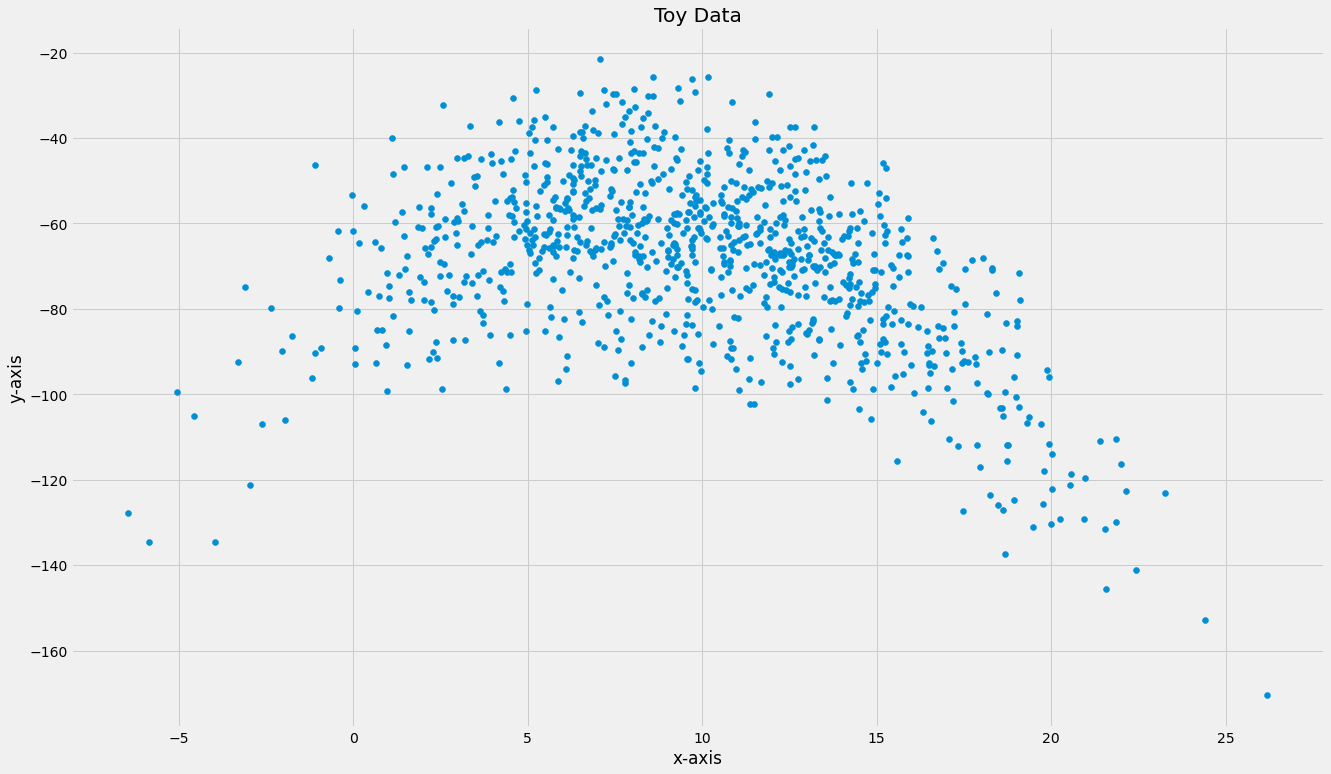

In [4]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 500)
    
    y = []
    
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = rand.uniform(rand.randint(-40,0),rand.randint(0,40))
        
        if linear:
            y.append(a*x[i] + b + noise)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            
    return x, y
    
x, y = f_toy(normal = True, linear = False)
plt.scatter(x,y)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [5]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

# convert data to array format for model fitting
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [6]:
# create Gaussian Process class
GP = Gaussian_Regression(x_train, y_train, x_test, y_test, 
                         l = 100, 
                         scale = 1e-10)
# train model
GP.train(x_train, y_train)

# apply trained model to test data
y_pred, MSE, std = GP.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.3079652053814495


In [7]:
# unnormalize
x_test = unnormalize(x_test, test[1]['x'], test[2]['x']), 
y_test = unnormalize(y_test, test[1]['y'],  test[2]['y'])
y_pred = unnormalize(y_pred, test[1]['y'],  test[2]['y'])

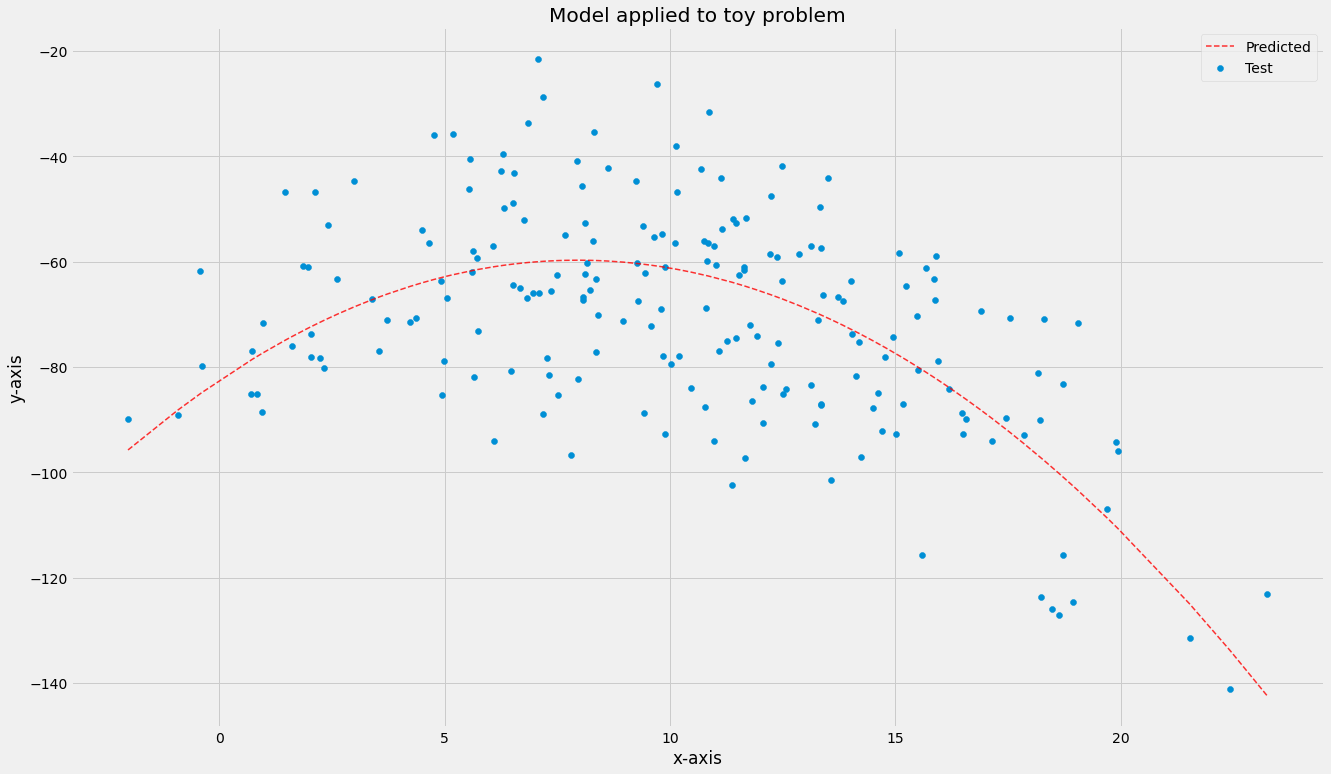

In [8]:
df_pred = pd.DataFrame(x_test[0], columns = ['x_test'])
df_pred['y_test'] = y_test
df_pred['y_pred'] = y_pred

df_pred.sort_values(by = ['x_test'], inplace = True)

plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(df_pred['x_test'],df_pred['y_pred'], 
         c = 'red', 
         linewidth = 1.5,
            alpha = 0.8,
         linestyle = '--',
         label = 'Predicted')


plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Model applied to toy problem')
plt.legend()

# Import and process data

In [9]:
df = pd.read_csv('maize_major_yield/maize_major_yield.csv')
df = df.drop(['year'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

#
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# Run Model to Predict Crop Yield

In [10]:
GP = Gaussian_Regression(x_train, y_train, x_test, y_test, 
                         l = 200, 
                         scale = 1e-6)

GP.train(x_train, y_train)

y_pred, MSE, std = GP.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.2783394245907469


In [11]:
# unnormalize
y_test = unnormalize(y_test, test[1][-1],  test[2][-1])
y_pred = unnormalize(y_pred, test[1][-1],  test[2][-1])

(-10.0, 30.0)

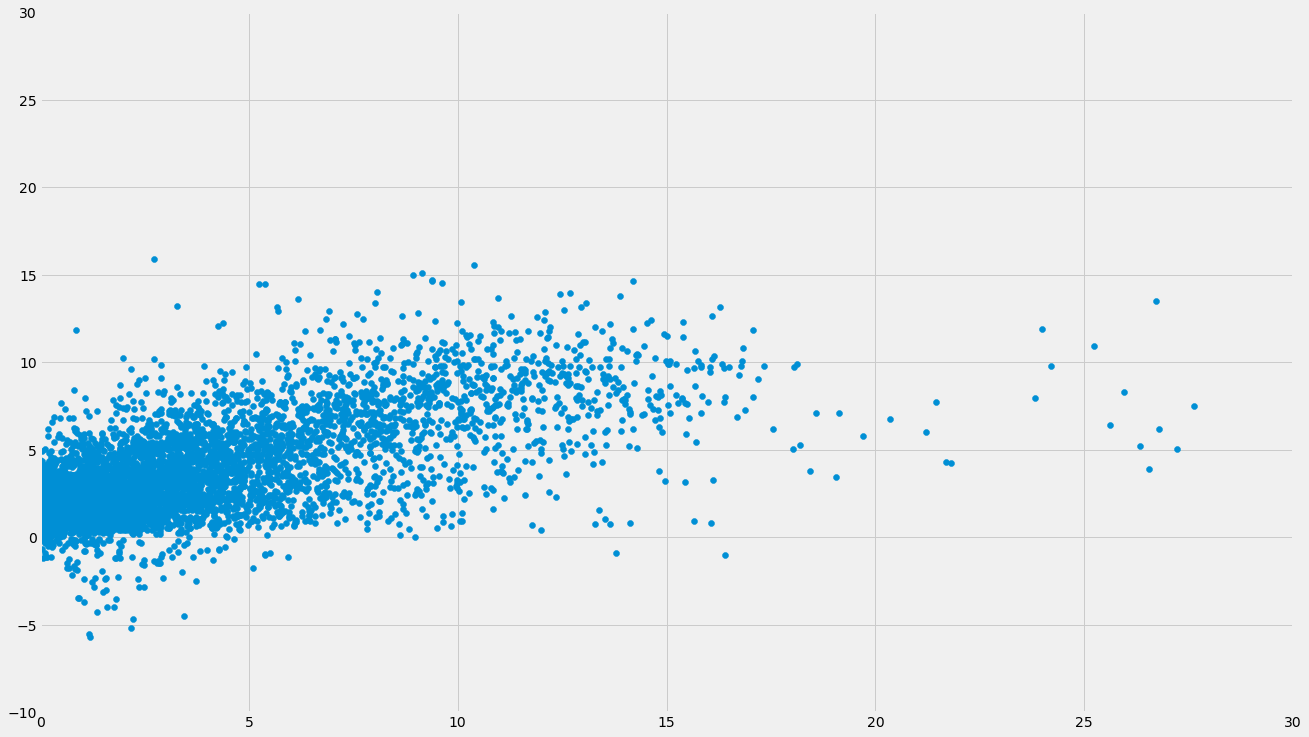

In [12]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_test'], df_pred['y_pred'])
plt.xlim(0,30)
plt.ylim(-10,30)

In [13]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.670085
y_pred,0.670085,1.000000


# Hyperparameter optimization with test data

In [ ]:

l_space = list(range(100,310,10))
scale_space = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]

previous_MSE = np.inf

results = []
best_results = {}

iteration = 0
for lv in l_space:
    for s in scale_space:
    
        iteration += 1

        # start timer
        start = time.time()

        GP = Gaussian_Regression(x_train, y_train, x_test, y_test, 
                         l = lv, 
                         scale = s)

        GP.train(x_train, y_train)

        y_pred, MSE, std = GP.predict(x_test)

        # end timer
        end = time.time()
        time_diff =  end - start


        params =[lv, s]

        iter_results = {'params':params,
                        'MSE':MSE,
                        'runtime':time_diff}

        results.append(iter_results)

        print(iteration - 1)
        #print("Current Step:", step, ' MSE: ', MSE)
        if MSE < previous_MSE:
            best_results.update({'iteration': iteration - 1})
            best_results.update({'params': params})
            best_results.update({'MSE': MSE})
            best_results.update({'runtime': time_diff})

            previous_MSE = MSE

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


In [ ]:
i = best_results['iteration']
results[i]

In [ ]:
best_l = results[i]['params'][0]
best_scale = results[i]['params'][1]

best_l = 230
best_scale = 1e-10

In [ ]:
GP = Gaussian_Regression(x_train, y_train, x_valid, y_valid, 
                         l = best_l, 
                         scale = best_scale)

GP.train(x_train, y_train)

y_pred, MSE, std = GP.predict(x_valid)

In [ ]:
y_pred = unnormalize(y_pred, valid[1][-1],  valid[2][-1])
y_valid = unnormalize(y_valid, valid[1][-1],  valid[2][-1])

In [ ]:
df_pred = pd.DataFrame(list(y_valid), columns = ['y_valid'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_valid'], df_pred['y_pred'])

In [ ]:
df_pred.corr()